
```js
{
    "a": -13.5,
    "dr": -1,
    "v": 0.4,
    "t": -0.2
}
```
a: angle between host and luggage
    angle in degree
    front is 0
    right is positive
dr: distance (relative) between host and luggage
    +1 is getting closer
    0 if distance constant
    -1 if distance getting shorter
d:
    distance between host and luggage

v: velocity of host?
t: direction of the host from the 

Angle in radian
Distance from 0.0 to 1.0 - keep at 0.5

the robot shouldnt move if within x distance - human can grab it

In [1]:
names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

# camera settings
# hfov = 67.0
# wr = 1280

hfov = 59
wr = 1080
hr = 720
avg_shoulder_width = 350.0
avg_torso_height = 460.0


In [2]:
from dataclasses import dataclass
from IPython.display import clear_output

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import pandas as pd
import cv2
import math
import time
import os
import queue

import torch
from ultralytics import YOLO
import mediapipe as mp



In [3]:
@dataclass
class Point:
    x: int = 0
    y: int = 0
    z: int = 0

    def distance(self, other):
        return np.sqrt((self.x - other.x) ** 2 + (self.y - other.y) ** 2 + (self.z - other.z) ** 2)
    
    def middle(self, other):
        return Point((self.x + other.x) / 2, (self.y + other.y) / 2, (self.z + other.z) / 2)
    
    def is_inside(self, other):
        return self.x >= 0 and self.x < other.x and self.y >= 0 and self.y < other.y


def landmark_point(landmark, frame_width, frame_height):
    return Point(int(landmark.x * frame_width), int(landmark.y * frame_height), int(landmark.z * frame_height))



In [4]:
# def distance_to_camera(hfov, wr, measured_width, pixel_width):
    # return (measured_width * wr) / (pixel_width * 2 * math.tan(math.radians(hfov / 2)))


def distance_to_camera(hfov, wr, measured_angle, measured_width, pixel_width):
    hfov_rad = math.radians(hfov)
    measured_angle_rad = math.radians(measured_angle)
    effective_pixel_width = pixel_width * math.cos(measured_angle_rad)
    distance = (measured_width * wr) / (effective_pixel_width * 2 * math.tan(hfov_rad / 2))
    return distance


def pixel_angle(hfov, wr, pixel_x):
    return (pixel_x - wr / 2) * hfov / wr


def grab_frame(cap):
    ret, frame = cap.read()
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


def get_objs(res):
    columns=['xmin', 'ymin', 'xmax', 'ymax', 'xcenter', 'score', 'class', 'name']
    df = pd.DataFrame(columns=columns)
    for r in res:
        for i in range(len(r.boxes.cls)):
            xyxy = np.array(r.boxes.xyxy[i].cpu(), dtype=int)
            df = pd.concat([df, pd.DataFrame({
                    'xmin': xyxy[0],
                    'ymin': xyxy[1],
                    'xmax': xyxy[2],
                    'ymax': xyxy[3],
                    'xcenter': int((xyxy[0] + xyxy[2]) / 2),
                    'score': float(r.boxes.conf[i]),
                    'class': int(r.boxes.cls[i]),
                    'name': names[int(r.boxes.cls[i])]
                }, index=[0])],
            ) 
    return df



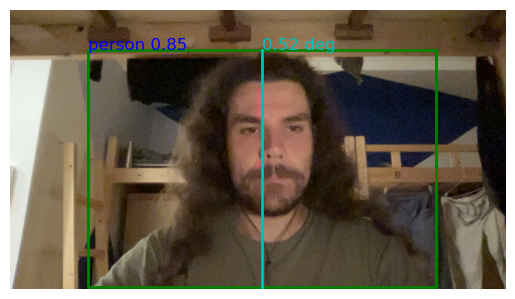

 0.10 deg


In [14]:
model = YOLO('yolov8s.pt')

try:
    # Initiate the camera
    prev_angle = 0.0
    vid = cv2.VideoCapture(0)
    time.sleep(0.5)

    while True:
        frame = grab_frame(vid)
        res = model(frame, verbose=False)
        objs = get_objs(res)

        clear_output(wait=True)

        fig, ax = plt.subplots()
        ax.imshow(frame)

        for index, obj in objs.iterrows():
            if obj['class'] != 0: continue
            if obj['score'] < 0.4: continue
            on_edge = obj['xmin'] < 10 or obj['xmax'] > wr - 10
            color = 'r' if on_edge else 'g'

            rect = patches.Rectangle((obj['xmin'], obj['ymin']), obj['xmax'] - obj['xmin'], obj['ymax'] - obj['ymin'], linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            text = f'{obj["name"]} {obj["score"]:.2f}'
            ax.text(obj['xmin'], obj['ymin'], text, color='b', fontsize=12)

            # draw vertical line at xcenter
            center = obj['xcenter']
            if on_edge:
                center = obj['xcenter'] // 2 if center < wr / 2 else (center + wr) // 2
            # angle_deg = (center - wr / 2) * hfov / wr
            angle_deg = pixel_angle(hfov, wr, center)
            ax.plot([center, center], [obj['ymin'], obj['ymax']], color='c', linewidth=2)
            ax.text(center, obj['ymin'], f'{angle_deg:.2f} deg', color='c', fontsize=12)

            mov_angle = angle_deg - prev_angle
            prev_angle = angle_deg

        plt.axis('off')
        plt.show()
        print(f' {mov_angle:.2f} deg')

        # save angle to csv with pandas - angle_deg and mov_angle
        # todo need to isolate one person only
        # todo add new on firts line
        pd.DataFrame({
            'a': [round(angle_deg, 2)],
            'da': [round(mov_angle, 2)]
        }).to_csv('var.csv', index=False, mode='a', header=False)
        
        # Frame rate
        plt.pause(0.15)
        # break

except KeyboardInterrupt:
    vid.release()  # Release the camera resource

vid.release()  # Release the camera resource if break

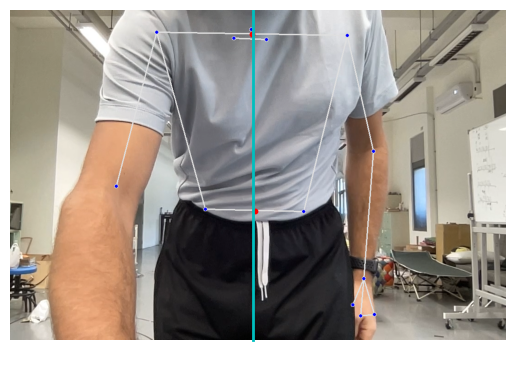

error: OpenCV(4.6.0) /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [6]:
def get_torso_properties(results, frame):
    left_shoulder = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER]
    right_shoulder = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER]
    left_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP]
    right_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP]

    left_shoulder_point = landmark_point(left_shoulder, frame.shape[1], frame.shape[0])
    right_shoulder_point = landmark_point(right_shoulder, frame.shape[1], frame.shape[0])
    left_hip_point = landmark_point(left_hip, frame.shape[1], frame.shape[0])
    right_hip_point = landmark_point(right_hip, frame.shape[1], frame.shape[0])

    shoulder_point = left_shoulder_point.middle(right_shoulder_point)
    hip_point = left_hip_point.middle(right_hip_point)
    
    torso_pixel_height = shoulder_point.distance(hip_point)
    shoulder_pixel_width = left_shoulder_point.distance(right_shoulder_point)

    return torso_pixel_height, shoulder_pixel_width, shoulder_point, hip_point


try:
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=False)

    # read video from file .mov file
    vid = cv2.VideoCapture('./Movie on 2023-11-23 at 10.03.mov')
    # skip to 2 frames per second of the video
    # vid.set(cv2.CAP_PROP_FPS, 2)

    # vid = cv2.VideoCapture(0)
    distance_queue = queue.Queue(maxsize=3)
    # distance_adjustment = -210

    while vid.isOpened():
        frame = grab_frame(vid)

        # skip 14 frames
        for i in range(14):
            vid.grab()
        # Frame rate
        # plt.pause(0.15)
        results = pose.process(frame)

        if results.pose_landmarks is not None:
            mp_drawing = mp.solutions.drawing_utils
            mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            torso_pixel_height, shoulder_pixel_width, shoulder_point, hip_point = get_torso_properties(results, frame)
            middle_point = shoulder_point.middle(hip_point)

            angle = pixel_angle(hfov, wr, middle_point.x)
            # distance = distance_to_camera(hfov, wr, angle, avg_shoulder_width, shoulder_pixel_width)
            distance = distance_to_camera(hfov, wr, angle, avg_torso_height, torso_pixel_height)

            angle = round(angle, 1)
            distance = int(distance // 10 * 10)

            if distance_queue.full():
                distance_queue.get()
            distance_queue.put(distance)

            sorted_queue = sorted(distance_queue.queue)
            index = round(len(sorted_queue) / 2)
            if distance_queue.full():
                # distance = np.mean(sorted_queue[index - 1:index + 1])
                distance = distance_queue.queue[index]
            else:
                distance = sorted_queue[round(len(sorted_queue) / 2)]
                distance = distance_queue.queue[-1]

            distance = int(distance // 10 * 10)

            print(f'{distance} mm')
            print(f'{angle} deg')

        clear_output(wait=True)
        fig, ax = plt.subplots()
        ax.imshow(frame)
        if results.pose_landmarks is not None:
            ax.scatter(shoulder_point.x, shoulder_point.y, c='r', s=10)
            ax.scatter(hip_point.x, hip_point.y, c='r', s=10)
            ax.plot([middle_point.x, middle_point.x], [0, frame.shape[0]], color='c', linewidth=2)
        plt.axis('off')
        plt.show()

        pd.DataFrame({
            't': [round(time.time(), 3)],
            'a': [angle],
            'd': [distance]
        }).to_csv('var.csv', index=False, mode='a', header=False)


except KeyboardInterrupt:
    vid.release()  # Release the camera resource

vid.release()  # Release the camera resource if break


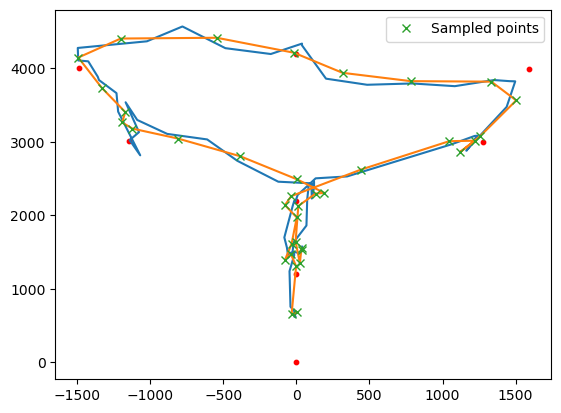

In [15]:
from scipy import interpolate
from scipy.interpolate import splrep, BSpline, splprep

# read csv
df = pd.read_csv('var_2fps.csv')
df.columns = ['t', 'a', 'd']

# plot angle and distance

# fig, ax = plt.subplots()
# ax.plot(df['a']**2, label='angle')
# ax.plot(df['d'], label='distance')
# ax.legend()
# plt.show()

# add column x and y
df['x'] = df['d'] * 1.15 * np.cos(np.radians(df['a']))
df['y'] = df['d'] * 1.15 * np.sin(np.radians(df['a']))

points = [
    Point(0, 0),
    Point(1200, 0),
    Point(2200, 0),
    Point(4200, 0),
    Point(3000, 1280),
    Point(3995, 1590),
    Point(3005, -1150),
    Point(4000, -1490),
]

# fig, ax = plt.subplots()
# ax.plot(df['y'], df['x'])
# for p in points:
#     ax.scatter(p.y, p.x, c='r', s=10)
# plt.show()


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import LSQUnivariateSpline

# Assuming df is your DataFrame with 'x' and 'y' columns
# df = pd.read_csv('your_data.csv')  # Uncomment this line if you need to load data from a CSV file

t = df.index

# Set the number of knots. Adjust this according to your data
# num_knots = 10
num_knots = int((t.max() - t.min()) // 4)
t_knots = np.linspace(t.min(), t.max(), num_knots)[1:-1]  # Exclude first and last points

# Fit the spline for 'x' and 'y' coordinates
spline_x = LSQUnivariateSpline(t, df['x'], t_knots)
spline_y = LSQUnivariateSpline(t, df['y'], t_knots)

num_samples = num_knots * 2
t_smooth = np.linspace(t.min(), t.max(), num_samples)

# Evaluate the spline at these points
x_sampled = spline_x(t_smooth)
y_sampled = spline_y(t_smooth)

# Create a DataFrame with the sampled data
sampled_df = pd.DataFrame({
    't': t_smooth,
    'x': x_sampled,
    'y': y_sampled
})

fig, ax = plt.subplots()
ax.plot(df['y'], df['x'])
for p in points:
    ax.scatter(p.y, p.x, c='r', s=10)
# ax.plot(spline_y(t_smooth), spline_x(t_smooth), label='Smoothed path')
ax.plot(spline_y(t_smooth), spline_x(t_smooth))
ax.plot(spline_y(t_smooth), spline_x(t_smooth), 'x', label='Sampled points')
ax.legend()
plt.show()

